In [6]:
from datetime import datetime
import numpy as np
import pandas as pd
import pandas_datareader
#import indicators
from db import timscale_setup
from db import dbscrape
from backtesting import Backtest
#from backtesting.test import SMA
from backtesting import Strategy
from backtesting.lib import crossover
import ta

import strategys_backtesting

In [3]:
import matplotlib.pyplot as plt
import finplot as fplt
import yfinance

In [ ]:
import PyAlgoTrade
import pytz
import pyfolio as pf
from collections import OrderedDict

#quandl.ApiConfig.api_key = "1dkdmifTyDZVCKaXnKTD"


In [4]:
import requests
from io import StringIO
from time import time

end_t = int(time()) 
start_t = end_t - 12*30*24*60*60 # twelve months
symbol = 'SPY'
interval = '1d'
url = 'https://query1.finance.yahoo.com/v7/finance/download/%s?period1=%s&period2=%s&interval=%s&events=history' % (symbol, start_t, end_t, interval)
r = requests.get(url)
df = pd.read_csv(StringIO(r.text))
df['Date'] = pd.to_datetime(df['Date']).astype('int64') // 1_000_000 # use finplot's internal representation, which is ms

df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,1568332800000,301.779999,302.170013,300.679993,301.089996,295.197144,62104800
1,1568592000000,299.839996,301.140015,299.450012,300.160004,294.285339,58191200
2,1568678400000,299.940002,301.019989,299.750000,300.920013,295.030457,41475500
3,1568764800000,300.489990,301.220001,298.239990,301.100006,295.206940,73375800
4,1568851200000,301.529999,302.630005,300.709991,301.079987,295.187317,76560500


In [ ]:
print("Fetching Data")
data = timscale_setup.get_full_table("BANKNIFTY_F1")
data.describe()
data.head()

In [9]:
print("Fetching using dbscrape")
banknifty_table = "BANKNIFTY_F1"

startdate = "2020-02-02 09:30:00"
enddate = "2020-02-29 15:30:00"

#data = dbscrape.gettablerange(*(timscale_setup.get_config()), banknifty_table, startdate, enddate)
rawdata = dbscrape.expirymonth(*(timscale_setup.get_config()), banknifty_table, 3, 2020)
rawdata.head()


Fetching using dbscrape


,datetime,internalname,open,high,low,close,volume,unknown,expirydate,exchange
0,2020-02-28 09:16:00,BANKNIFTY MAR FUT,29625.00,29650.00,29375.60,29587.75,146320,1005900,2020-03-26 23:59:00,NSE
1,2020-02-28 09:17:00,BANKNIFTY MAR FUT,29600.00,29635.95,29572.40,29594.65,70100,1005900,2020-03-26 23:59:00,NSE
2,2020-02-28 09:18:00,BANKNIFTY MAR FUT,29582.55,29582.55,29550.00,29580.00,64000,1061780,2020-03-26 23:59:00,NSE
3,2020-02-28 09:19:00,BANKNIFTY MAR FUT,29578.05,29636.20,29577.70,29592.00,35100,1061780,2020-03-26 23:59:00,NSE
4,2020-02-28 09:20:00,BANKNIFTY MAR FUT,29592.75,29665.25,29592.35,29638.20,43160,1061780,2020-03-26 23:59:00,NSE


In [24]:
import datetime as dt

print(dt.datetime.fromtimestamp(rawdata["datetime"][100]))
rawdata["datetime"][100].time() < dt.time(15,30)

TypeError: an integer is required (got type Timestamp)

In [29]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

model = Sequential()
model.add(LSTM(100, input_shape=(22, 60)))
model.add(Dropout(0.1))
model.add(Dense(4, activation='softmax'))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
lstm (LSTM)                  (None, 100)               64400
_________________________________________________________________
dropout (Dropout)            (None, 100)               0
_________________________________________________________________
dense (Dense)                (None, 4)                 404
Total params: 64,804
Trainable params: 64,804
Non-trainable params: 0
_________________________________________________________________


In [1]:
import DLPriceModel

test_record = "../data/tfrecords/dl_scaled_5_BANKNIFTY_F1_2020_1.tfrecords"
X, Y = DLPriceModel.create_dataset(test_record)
for i in range(len(X[0])):
    print(X[0][i][:3])

True
[[0.51987529]
 [0.53510904]
 [0.40490812]]
[[0.55115205]
 [0.54973185]
 [0.41527024]]
[[0.50280875]
 [0.38480276]
 [0.24850836]]
[[0.55115205]
 [0.4120172 ]
 [0.30700752]]
[[0.10161054]
 [0.39853588]
 [0.48784775]]
[[9.51422815e-08]
 [9.51400510e-08]
 [9.51378146e-08]]
[[0.58738774]
 [0.5344584 ]
 [0.47530866]]
[[0.7349329 ]
 [0.71575582]
 [0.68971562]]
[[0.56006223]
 [0.48604366]
 [0.39652163]]
[[0.62801898]
 [0.58481705]
 [0.52925354]]
[[0.70424324]
 [0.68337619]
 [0.65648705]]
[[0.17439504]
 [0.13484344]
 [0.08419872]]
[[0.7349329 ]
 [0.71575582]
 [0.68971562]]
[[0.94164366]
 [0.96351045]
 [0.98900312]]
[[0.52822208]
 [0.46800914]
 [0.39042813]]
[[0.31355083]
 [0.37585488]
 [0.45413032]]
[[0.47066024]
 [0.4895317 ]
 [0.50713003]]
[[0.68742263]
 [0.62060046]
 [0.55049354]]
[[1.30795504]
 [0.92278933]
 [0.71424436]]
[[0.58581674]
 [0.5341807 ]
 [0.46151894]]
[[0.59698105]
 [0.51324302]
 [0.47394186]]
[[0.81137431]
 [0.71382123]
 [0.69809139]]


In [27]:
from progress.bar import Bar
import time
bar = Bar('Processing', max=20)
for i in range(20):
    time.sleep(1)
    bar.next()
bar.finish()

In [11]:
rawdata.tail()

,datetime,internalname,open,high,low,close,volume,unknown,expirydate,exchange
7033,2020-03-26 15:27:00,BANKNIFTY MAR FUT,19624.80,19628.7,19618.95,19623.00,9360,812080,2020-03-26 23:59:00,NSE
7034,2020-03-26 15:28:00,BANKNIFTY MAR FUT,19621.15,19623.0,19616.05,19621.75,6060,798600,2020-03-26 23:59:00,NSE
7035,2020-03-26 15:29:00,BANKNIFTY MAR FUT,19621.70,19624.0,19618.30,19623.70,8200,798600,2020-03-26 23:59:00,NSE
7036,2020-03-26 15:30:00,BANKNIFTY MAR FUT,19622.05,19624.2,19620.10,19621.00,7520,798600,2020-03-26 23:59:00,NSE
7037,2020-03-26 18:22:00,BANKNIFTY MAR FUT,19613.90,19613.9,19613.90,19613.90,1,675140,2020-03-26 23:59:00,NSE


In [12]:
rawdata.describe()

,open,high,low,close,volume,unknown
count,7038.000000,7038.000000,7038.000000,7038.000000,7038.000000,7.038000e+03
mean,23938.511687,23968.859584,23907.998146,23938.149517,16317.263285,1.341751e+06
std,4323.159168,4312.459628,4333.089143,4322.867640,14260.867193,2.242902e+05
min,16074.650000,16163.800000,16020.550000,16076.000000,1.000000,6.751400e+05
25%,19987.762500,20028.887500,19935.462500,19990.337500,7340.000000,1.208760e+06
50%,24231.375000,24269.275000,24188.525000,24226.850000,12280.000000,1.336520e+06
75%,28616.175000,28633.450000,28597.112500,28619.075000,20540.000000,1.500600e+06
max,29635.000000,29665.250000,29610.100000,29638.200000,231560.000000,1.881900e+06


In [4]:
import charts

fplot = charts.FinPlotter(rawdata, format="db")
fplot.data.head()

,datetime,internalname,Open,High,Low,Close,Volume,unknown,expirydate,exchange
0,2020-02-28 09:16:00,BANKNIFTY MAR FUT,29625.00,29650.00,29375.60,29587.75,146320,1005900,2020-03-26 23:59:00,NSE
1,2020-02-28 09:17:00,BANKNIFTY MAR FUT,29600.00,29635.95,29572.40,29594.65,70100,1005900,2020-03-26 23:59:00,NSE
2,2020-02-28 09:18:00,BANKNIFTY MAR FUT,29582.55,29582.55,29550.00,29580.00,64000,1061780,2020-03-26 23:59:00,NSE
3,2020-02-28 09:19:00,BANKNIFTY MAR FUT,29578.05,29636.20,29577.70,29592.00,35100,1061780,2020-03-26 23:59:00,NSE
4,2020-02-28 09:20:00,BANKNIFTY MAR FUT,29592.75,29665.25,29592.35,29638.20,43160,1061780,2020-03-26 23:59:00,NSE


In [10]:
data_backtesting = strategys_backtesting.prepareData(rawdata, True)
data_backtesting.head()

,Open,High,Low,Close,Volume
datetime,,,,,
2020-02-28 09:16:00,29625.00,29650.00,29375.60,29587.75,146320
2020-02-28 09:17:00,29600.00,29635.95,29572.40,29594.65,70100
2020-02-28 09:18:00,29582.55,29582.55,29550.00,29580.00,64000
2020-02-28 09:19:00,29578.05,29636.20,29577.70,29592.00,35100
2020-02-28 09:20:00,29592.75,29665.25,29592.35,29638.20,43160


In [6]:

fplot = charts.FinPlotter(data_backtesting)
fplot.data.head()

,Open,High,Low,Close,Volume
datetime,,,,,
2020-02-28 09:16:00,29625.00,29650.00,29375.60,29587.75,146320
2020-02-28 09:17:00,29600.00,29635.95,29572.40,29594.65,70100
2020-02-28 09:18:00,29582.55,29582.55,29550.00,29580.00,64000
2020-02-28 09:19:00,29578.05,29636.20,29577.70,29592.00,35100
2020-02-28 09:20:00,29592.75,29665.25,29592.35,29638.20,43160


In [9]:
fplot.indiPlot(name=banknifty_table)

AttributeError: 'DataFrame' object has no attribute 'open'

In [8]:
ta.volatility.bollinger_hband(data_backtesting["Close"], 20, 2)

2020-03-27 09:16:00             NaN
2020-03-27 09:17:00             NaN
2020-03-27 09:18:00             NaN
2020-03-27 09:19:00             NaN
2020-03-27 09:20:00             NaN
                           ...     
2020-04-30 15:27:00    21558.079761
2020-04-30 15:28:00    21550.470075
2020-04-30 15:29:00    21542.249257
2020-04-30 15:30:00    21541.496941
2020-04-30 19:28:00    21541.281955
Name: hband, Length: 7914, dtype: float64

In [24]:
len(ta.volatility.bollinger_hband_indicator(data_backtesting["Close"], 20, 2))

8287

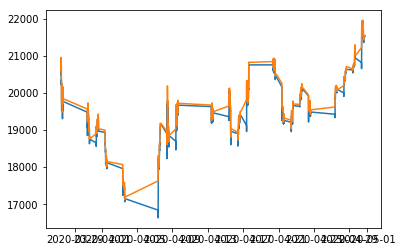

In [20]:


#plt.plot(data_backtesting.index[100:200], ta.volatility.bollinger_hband_indicator(data_backtesting["Close"][100:200], 20, 2))
plt.plot(data_backtesting.index, ta.volatility.bollinger_lband(data_backtesting["Close"], 20, 2))
#plt.plot(data_backtesting.index[100:200], ta.volatility.bollinger_mavg(data_backtesting["Close"][100:200], 20))
#plt.plot(data_backtesting.index[100:200], data_backtesting["Close"][100:200])

plt.plot(data_backtesting.index, ta.volume.volume_weighted_average_price(data_backtesting["High"],data_backtesting["Low"],data_backtesting["Close"], data_backtesting["Volume"], 14))
plt.show()

In [5]:

def SMA(values, n):
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).rolling(n).mean()

class SmaCross(Strategy):
    # Define the two MA lags as *class variables*
    # for later optimization
    n1 = 13
    n2 = 32
    
    def init(self):
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        # If sma1 crosses above sma2, close any existing
        # short trades, and buy the asset
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()

        # Else, if sma1 crosses below sma2, close any existing
        # long trades, and sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell()



In [ ]:
class SmaCrossSignalTrail(SignalStrategy,
               TrailingStrategy):
    n1 = 10
    n2 = 25
    
    def init(self):
        # In init() and in next() it is important to call the
        # super method to properly initialize the parent classes
        super().init()
        
        # Precompute the two moving averages
        sma1 = self.I(SMA, self.data.Close, self.n1)
        sma2 = self.I(SMA, self.data.Close, self.n2)
        
        # Where sma1 crosses sma2 upwards. Diff gives us [-1,0, *1*]
        signal = (pd.Series(sma1) > sma2).astype(int).diff().fillna(0)
        signal = signal.replace(-1, 0)  # Upwards/long only
        
        # Use 95% of available liquidity (at the time) on each order.
        # (Leaving a value of 1. would instead buy a single share.)
        entry_size = signal * .95
                
        # Set order entry sizes using the method provided by 
        # `SignalStrategy`. See the docs.
        self.set_signal(entry_size=entry_size)
        
        # Set trailing stop-loss to 2x ATR using
        # the method provided by `TrailingStrategy`
        self.set_trailing_sl(2)


In [ ]:
from backtesting.test import GOOG

GOOG.head()

In [ ]:

bt = Backtest(GOOG, SmaCross, cash=10000, commission=.002)
stats = bt.run()
stats

In [6]:
bt_banknifty = Backtest(data_backtesting, SmaCross, cash=100000, commission=.002)
banknifty_stats = bt_banknifty.run()

print(banknifty_stats)

Start                     2020-01-01 09:16:00
End                       2020-01-30 19:10:00
Duration                     29 days 09:54:00
Exposure Time [%]                     99.0226
Equity Final [$]                      59647.8
Equity Peak [$]                        100000
Return [%]                           -40.3522
Buy & Hold Return [%]                 5.57261
Max. Drawdown [%]                    -40.3661
Avg. Drawdown [%]                    -40.3661
Max. Drawdown Duration       29 days 08:37:00
Avg. Drawdown Duration       29 days 08:37:00
# Trades                                  301
Win Rate [%]                          12.6246
Best Trade [%]                       0.864226
Worst Trade [%]                       -1.8407
Avg. Trade [%]                      -0.216793
Max. Trade Duration           2 days 18:39:00
Avg. Trade Duration           0 days 02:20:00
Profit Factor                        0.120486
Expectancy [%]                       0.275713
SQN                               

In [8]:
banknifty_stats["Return [%]"]

-40.352237700000146

In [ ]:

bt_banknifty.plot()

In [ ]:
bt.plot()

In [ ]:
%%time

stats = bt_banknifty.optimize(n1=range(8, 15, 1),
                    n2=range(20, 35, 1),
                    maximize='Equity Final [$]',
                    constraint=lambda param: param.n1 < param.n2)
print(stats)

In [ ]:
print(stats._strategy)
stats.tail()

In [ ]:
bt_banknifty.plot(plot_volume=False, plot_pl=False)

In [ ]:
bt_banknifty._strategy.__name__